# 🏨 A호텔 수익 극대화 시뮬레이션

---

## 📘 문제 설명

시내에 위치한 A호텔은 리모델링을 고려 중이며, 수익의 평균을 극대화하기 위해 **최적의 요금과 객실 크기 조합**을 찾고자 한다.  
A호텔은 현재 **총 450개의 객실**을 다음과 같이 세 가지 형태로 운영 중이다.

---

### 🛏️ 객실 정보 요약

---

#### 📦 스탠다드 객실
- **일 요금**: \$85  
- **평균 판매량 (H)**: 250개  
- **수익**: \$21,250  
- **가격/수요 탄력성 (E)**: `U(-4.5, -1.0)`  
- **새로운 요금 범위 (N)**: 70 ~ 90 달러

---

#### 🥇 골드 객실
- **일 요금**: \$98  
- **평균 판매량 (H)**: 100개  
- **수익**: \$9,800  
- **가격/수요 탄력성 (E)**: `U(-1.5, -0.5)`  
- **새로운 요금 범위 (N)**: 90 ~ 110 달러

---

#### 💎 플래티늄 객실
- **일 요금**: \$139  
- **평균 판매량 (H)**: 50개  
- **수익**: \$6,950  
- **가격/수요 탄력성 (E)**: `U(-3.0, -1.0)`  
- **새로운 요금 범위 (N)**: 120 ~ 149 달러

---

### 📝 참고
- 탄력성 `U(a, b)`는 **Uniform 분포(균등분포)**를 의미합니다.  
  예: `U(-4.5, -1.0)` → -4.5와 -1.0 사이의 값에서 무작위 추출
- 모든 요금은 **1달러 단위**로 설정되어야 합니다.


## 📐 수요 예측 공식

각 객실에 대해 **예상 판매 객실 수 (Q)**는 아래와 같은 수식을 따릅니다:

$$
Q = H + E \times H \times \left(\frac{N - C}{C}\right)
$$

- $H$ : 일일 평균 판매 객실 수  
- $E$ : 가격/수요 탄력성  
- $N$ : 새로운 요금  
- $C$ : 현재 요금

---

## 🎯 제약 조건

- **전체 예상 판매 객실 수의 합 ≤ 430**이 될 확률이 **80% 이상**이어야 함
- 각 객실의 요금은 **1달러 단위로 설정**
- A호텔은 현재 **총 450개 객실**을 초과하여 확장할 계획은 없음

---

## 🧠 목적

> **예상 수익의 합의 평균을 최대화하기 위한**  
> **각 객실 형태의 새로운 요금을 구하라.**

---

## 🧰 코드 셋업 (Colab 상단에 붙여넣기)

```python
import numpy as np
import pandas as pd
from pandas import *
import mcerp
from mcerp import *
import scipy.stats as ss
from scipy.stats import *
from geneticalgorithm import geneticalgorithm as ga
import matplotlib.pyplot as plt

np.random.seed(0)
mcerp.npts = 10000
```


## 물음1
A호텔의 예상수익의 합의 평균을 최대화하는 각 객실형태의 새로운 요금을 구한 경우, 예상수익의 합의 평균을 소수점 첫째자리에서 반올림하여 숫자만 입력하라.

 The best solution found:                                                                           
 [ 90. 101. 123.]

 Objective function:
 -41417.6337


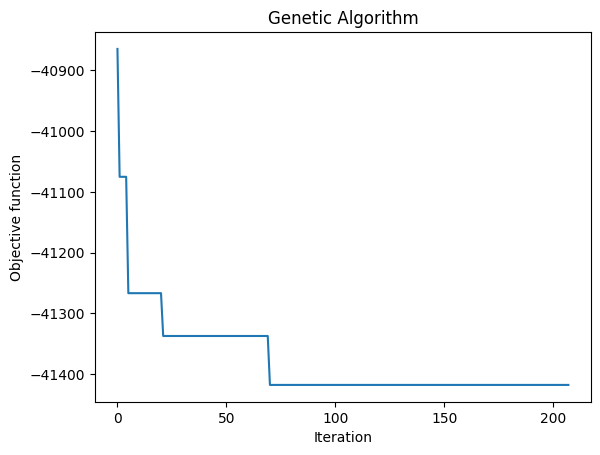

Optimal Room Prices (Standard, Gold, Platinum): [ 90. 101. 123.]
Rounded Expected Total Revenue: 41418


In [2]:
# 📦 라이브러리 임포트
import numpy as np
import pandas as pd
from pandas import *
import mcerp
from mcerp import *
import scipy.stats as ss
from scipy.stats import *
from geneticalgorithm import geneticalgorithm as ga
import matplotlib.pyplot as plt

# ✅ 랜덤 시드 고정 (재현 가능성 확보)
np.random.seed(0)
mcerp.npts = 10000  # mcerp 시뮬레이션 포인트 수 설정

# 📌 탄력성 입력 분포 정의 (각 객실 형태별로 불확실한 수요 민감도 설정)
elasticity_std = U(-4.5, -1.0)     # 스탠다드 객실
elasticity_gold = U(-1.5, -0.5)    # 골드 객실
elasticity_plat = U(-3.0, -1.0)    # 플래티늄 객실

# mcerp 객체로부터 샘플 배열 추출
elasticity_std = elasticity_std._mcpts
elasticity_gold = elasticity_gold._mcpts
elasticity_plat = elasticity_plat._mcpts

# 📌 과거 일일 평균 판매 객실 수 (H)
avg_demand_std = 250
avg_demand_gold = 100
avg_demand_plat = 50

# 📌 현재 요금 (C)
price_now_std = 85
price_now_gold = 98
price_now_plat = 139

# 🎯 목적 함수 정의
def objective(x):
    # 전역변수 사용 선언
    global elasticity_std, elasticity_gold, elasticity_plat
    global avg_demand_std, avg_demand_gold, avg_demand_plat
    global price_now_std, price_now_gold, price_now_plat

    # 🔢 최적화 대상 변수: 새로운 요금 제안
    new_price_std = x[0]
    new_price_gold = x[1]
    new_price_plat = x[2]

    # 🧮 각 객실 유형별 예상 판매 객실 수 (공식 적용)
    est_demand_std = np.round(
        avg_demand_std + elasticity_std * avg_demand_std * (new_price_std - price_now_std) / price_now_std
    )
    est_demand_gold = np.round(
        avg_demand_gold + elasticity_gold * avg_demand_std * (new_price_gold - price_now_gold) / price_now_gold
    )
    est_demand_plat = np.round(
        avg_demand_plat + elasticity_plat * avg_demand_std * (new_price_plat - price_now_plat) / price_now_plat
    )

    # 📊 총 객실 판매 수 합
    total_est_demand = est_demand_std + est_demand_gold + est_demand_plat

    # ❗ 제약조건: 객실 총합이 430 이하인 샘플이 80% 미만일 경우 페널티 부여
    penalty = 0
    if np.count_nonzero(total_est_demand <= 430) / total_est_demand.size <= 0.8:
        penalty = 1_000_000

    # 💰 총 예상 수익 = 객실 단가 × 예상 판매 객실 수 - 페널티
    revenue_total = (
        new_price_std * est_demand_std +
        new_price_gold * est_demand_gold +
        new_price_plat * est_demand_plat -
        penalty
    )

    # 🎯 평균 수익의 음수 리턴 (최대화를 위한 최소화 목적)
    return -np.mean(revenue_total)

# 🔧 변수 경계 (요금 범위)
price_bounds = np.array([
    [70, 90],     # 스탠다드
    [90, 110],    # 골드
    [120, 149]    # 플래티늄
])

# ⚙️ 유전 알고리즘 실행
model = ga(
    function=objective,
    dimension=3,
    variable_type='int',           # 요금 단위는 1달러 단위이므로 정수 처리
    variable_boundaries=price_bounds
)

# 🏃 실행
model.run()

# ✅ 최적 요금 출력
print("Optimal Room Prices (Standard, Gold, Platinum):", model.output_dict['variable'])

# ✅ 최적 요금에서의 예상 수익 평균 출력
x_opt = model.output_dict['variable']

# 다시 수익 계산
new_price_std = x_opt[0]
new_price_gold = x_opt[1]
new_price_plat = x_opt[2]

est_demand_std = np.round(
    avg_demand_std + elasticity_std * avg_demand_std * (new_price_std - price_now_std) / price_now_std
)
est_demand_gold = np.round(
    avg_demand_gold + elasticity_gold * avg_demand_std * (new_price_gold - price_now_gold) / price_now_gold
)
est_demand_plat = np.round(
    avg_demand_plat + elasticity_plat * avg_demand_std * (new_price_plat - price_now_plat) / price_now_plat
)

revenue_total = (
    new_price_std * est_demand_std +
    new_price_gold * est_demand_gold +
    new_price_plat * est_demand_plat
)

# 🎯 최종 제출값: 예상 수익 평균의 소수점 첫째 자리 반올림
print("Rounded Expected Total Revenue:", round(np.mean(revenue_total)))
